# Fluvial flood inundation mapping detailed workflow


### [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/passah2o/pygeoflood/blob/master/doc/examples/fim_workflow_combined.ipynb)

On Google Colab, run the following command to install pygeoflood:

```bash
%pip install git+https://github.com/passah2o/pygeoflood
```


### Import libraries


In [1]:
from pathlib import Path
from pygeoflood import PyGeoFlood

### Instantiate **pygeoflood** model class


In [2]:
pgf = PyGeoFlood(dem_path="data/OC1mTest.tif")

### Set paths to input datasets


In [3]:
pgf.flowline_path = "data/Flowline.shp"
pgf.catchment_path = "data/Catchment.shp"

# # we are not using these datasets for this example
# pgf.streamflow_forecast_path = "data/prod_nwm.t00z.analysis_assim.channel_rt.tm00.conus.nc"
# pgf.custom_flowline_path = Path(data_dir, "NHDPlus_H_1209_HU4_GDB.gdb")

### Download input datasets if necessary


In [4]:
# make data directory if it doesn't exist
if not Path("data").is_dir():
    Path("data").mkdir()
# download input datasets if they doesn't exist
# DEM from USGS 3DEP
if not pgf.dem_path.is_file():
    !curl https://utexas.box.com/shared/static/id0in7w8yn38o59sexa50aqunsr7mzk0.tif -Lso data/OC1mTest.tif
# flowlines and catchments from NFIE (NHD MR) dataset
# https://www.arcgis.com/home/webmap/viewer.html?webmap=9766a82973b34f18b43dafa20c5ef535
if not pgf.flowline_path.is_file():
    !curl -sL https://utexas.box.com/shared/static/s1vlnymonbidnhul52oja7s83ky1212j.tgz | tar -xz -C data
if not pgf.catchment_path.is_file():
    !curl -sL https://utexas.box.com/shared/static/jzawwvmb2tjl4yqtnitgvfjcc4ho4tg5.tgz | tar -xz -C data

### Fluvial inundation mapping steps


In [5]:
# apply nonlinear filter to DEM
pgf.apply_nonlinear_filter()

Running apply_nonlinear_filter with parameters:
    custom_dem = None
    custom_path = None
    method = PeronaMalik2
    smoothing_quantile = 0.9
    time_increment = 0.1
    n_iter = 50
    sigma_squared = 0.05
Computing slope of raw DTM
DEM slope array shape: (3378, 4750)
Computing lambda = q-q-based nonlinear filtering threshold
DEM smoothing Quantile: 0.9
Edge Threshold Value: 0.34356024861335754
Filtered DEM written to data/OC1mTest_filtered.tif
apply_nonlinear_filter completed in 11.6311 seconds



In [6]:
# calculate slope
pgf.calculate_slope()

Running calculate_slope with parameters:
    custom_filtered_dem = None
    custom_path = None
 slope statistics
 min angle: 0.0
 max angle: 54.863846043721324
 mean slope: 0.13960592
 stdev slope: 0.15432632
Slope raster written to data/OC1mTest_slope.tif
calculate_slope completed in 1.2685 seconds



In [7]:
# calculate curvature
pgf.calculate_curvature()

Running calculate_curvature with parameters:
    custom_filtered_dem = None
    custom_path = None
    method = geometric
 using geometric curvature
 curvature statistics
 non-nan curvature cell number: 16045500
 non-nan finite curvature cell number:  mean:  -0.00031314598
 standard deviation:  0.112147875
Curvature raster written to data/OC1mTest_curvature.tif
calculate_curvature completed in 1.4374 seconds



In [8]:
# fill depressions on filtered DEM
pgf.fill_depressions()

Running fill_depressions with parameters:
    custom_filtered_dem = None
    custom_path = None
./whitebox_tools --run="FillDepressions" --dem='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_filtered.tif' --output='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_filled.tif' --fix_flats -v --compress_rasters=True

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Fixing flow on flats...
Flats increment value: 0.000002
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.168s
Filled DEM written to data/OC1mTest_filled.tif
fill_depressions completed in 7.9343 seconds



In [9]:
# calculate MFD flow accumulation
pgf.calculate_mfd_flow_accumulation()

Running calculate_mfd_flow_accumulation with parameters:
    custom_filled_dem = None
    custom_path = None
./whitebox_tools --run="QuinnFlowAccumulation" --dem='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_filled.tif' --output='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_mfd_fac.tif' --out_type=cells --exponent=1.0 -v --compress_rasters=True

************************************
* Welcome to QuinnFlowAccumulation *
* Powered by WhiteboxTools         *
* www.whiteboxgeo.com              *
************************************
Saving data...
Output file written

Elapsed Time (Including I/O): 5.352s
MFD flow accumulation raster written to data/OC1mTest_mfd_fac.tif
calculate_mfd_flow_accumulation completed in 5.3610 seconds



In [10]:
# calculate D8 flow directions
pgf.calculate_d8_flow_direction()

Running calculate_d8_flow_direction with parameters:
    custom_filled_dem = None
    custom_filtered_dem = None
    custom_path = None
./whitebox_tools --run="D8Pointer" --dem='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_filled.tif' --output='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_d8_fdr.tif' -v --compress_rasters=True

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.90s
D8 flow direction raster written to data/OC1mTest_d8_fdr.tif
calculate_d8_flow_direction completed in 2.1590 seconds



In [11]:
# calculate outlets
pgf.find_outlets()

Running find_outlets with parameters:
    custom_d8_fdr = None
    custom_path = None
Outlets raster written to data/OC1mTest_outlets.tif
find_outlets completed in 0.1952 seconds



In [12]:
# delineate basins
pgf.delineate_basins()

Running delineate_basins with parameters:
    custom_d8_fdr = None
    custom_path = None
./whitebox_tools --run="Basins" --d8_pntr='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_d8_fdr.tif' --output='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_basins.tif' -v --compress_rasters=True

****************************
* Welcome to Basins        *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.305s
Basins raster written to data/OC1mTest_basins.tif
delineate_basins completed in 1.0048 seconds



In [13]:
# define channel skeletons
pgf.define_skeleton()

Running define_skeleton with parameters:
    custom_curvature = None
    custom_mfd_fac = None
    custom_path = None
    fac_threshold = 3000
    write_flow_skeleton = False
    write_curvature_skeleton = False
Curvature mean:  -0.00031413726
Curvature standard deviation:  0.11232527
Curvature Projection: EPSG:6343
Mean upstream flow:  2617.36
Combined skeleton written to data/OC1mTest_combined_skeleton.tif
define_skeleton completed in 0.8890 seconds



In [14]:
# geodesic distance (not needed for GeoFlood workflow)
# pgf.calculate_geodesic_distance(write_cost_function=True) # uncomment this if identifying channel heads

In [15]:
# get channel heads (not needed for GeoFlood workflow)
# pgf.identify_channel_heads() # uncomment this if identifying channel heads

In [16]:
# get flowline endpoints
pgf.find_endpoints()

Running find_endpoints with parameters:
    custom_flowline = None
    custom_path = None
Endpoints csv written to data/OC1mTest_endpoints.csv
find_endpoints completed in 0.0554 seconds



In [17]:
# get binary HAND array
pgf.calculate_binary_hand()

Running calculate_binary_hand with parameters:
    custom_dem = None
    custom_flowline = None
    custom_path = None
Binary HAND raster written to data/OC1mTest_binary_hand.tif
calculate_binary_hand completed in 7.1748 seconds



In [18]:
# # get custom flowline from NHD HR dataset (optional)
# pgf.rasterize_custom_flowline(layer="NHDFlowline")

In [19]:
# extract channel network
pgf.extract_channel_network()

Running extract_channel_network with parameters:
    custom_flowline = None
    custom_curvature = None
    custom_mfd_fac = None
    custom_endpoints = None
    custom_binary_hand = None
    custom_path = None
    retrace_flowline = True
    vector_extension = shp
    write_cost_function = False
    use_custom_flowline = False
    no_flowline = False
    custom_weight_curvature = None
    custom_weight_mfd_fac = None
    custom_weight_binary_hand = None
    custom_weight_custom_flowline = None
Retracing flowline...
Cost function weights:
curvature          0.2520 (mean flow accumulation)
mfd_fac            1.0000
binary_hand        0.7500
custom_flowline    0.0000
0.25195235 1 0.75 0
Cost min: 0.5028838188775905
Cost max: inf
cost shape: (3378, 4750)
Creating path 1/1: RAM usage: 4.06/54.92 GB (7.4%)
Number of endpoints: 1
Channel network raster written to data/OC1mTest_channel_network_raster.tif
Channel network vector written to data/OC1mTest_channel_network.shp
extract_channel_netwo

In [20]:
# calculate HAND
pgf.calculate_hand()

Running calculate_hand with parameters:
    custom_filled_dem = None
    custom_channel_network_raster = None
    custom_path = None
./whitebox_tools --run="ElevationAboveStream" --dem='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_filled.tif' --streams='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_channel_network_raster.tif' --output='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_HAND.tif' -v --compress_rasters=True

***********************************
* Welcome to ElevationAboveStream *
* Powered by WhiteboxTools        *
* www.whiteboxgeo.com             *
***********************************
Reading DEM data...
Reading streams data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.509s
**********************************************************************************
DEM needs to be processed to remove topographic depressions and flats prior to
running this tool.
*************************************************************************

In [21]:
# segment flowline
pgf.segment_channel_network()

Running segment_channel_network with parameters:
    custom_channel_network_vector = None
    custom_path = None
    vector_extension = shp
    segment_length = 1000
Segmented channel network written to data/OC1mTest_segmented_channel_network.shp
segment_channel_network completed in 1.0009 seconds



In [22]:
# delineate channel network segment catchments
pgf.delineate_segment_catchments()

Running delineate_segment_catchments with parameters:
    custom_segmented_channel_network = None
    custom_d8_fdr = None
    custom_path = None
./whitebox_tools --run="Watershed" --d8_pntr='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_d8_fdr.tif' --pour_pts='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_segmented_channel_network_raster.tif' --output='/home/mark/repos/pygeoflood/doc/examples/data/OC1mTest_segment_catchments.tif' -v --compress_rasters=True

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.599s
Segment catchments written to data/OC1mTest_segment_catchments.tif
delineate_segment_catchments completed in 1.4301 seconds



In [23]:
# convert channel network segment catchments raster to shapefile
# (not needed for FIM workflow)
pgf.vectorize_segment_catchments()

Running vectorize_segment_catchments with parameters:
    custom_segment_catchments_raster = None
    custom_path = None
Segment catchments vector file written to data/OC1mTest_segment_catchments.shp
vectorize_segment_catchments completed in 0.3596 seconds



In [24]:
# calculate synthetic rating curves table
pgf.calculate_src()

Running calculate_src with parameters:
    custom_dem = None
    custom_segmented_channel_network = None
    custom_segment_catchments_raster = None
    custom_catchments = None
    custom_hand = None
    custom_path = None
    min_slope = 1e-06
    max_stage = 20
    incr_stage = 0.1
    custom_roughness_path = None
River attributes written to data/OC1mTest_river_attributes.csv
Synthetic rating curves written to data/OC1mTest_src.csv
calculate_src completed in 5.7083 seconds



In [25]:
# calculate flood stage from synthetic rating curves
# pgf.streamflow_forecast_path must be set or custom_Q must be provided
pgf.calculate_flood_stage(custom_Q=500)

Running calculate_flood_stage with parameters:
    custom_src = None
    custom_streamflow_forecast_path = None
    custom_path = None
    custom_Q = 500
Applying custom streamflow to each segment: 500 cms
Flood stages written to data/OC1mTest_flood_stage.csv
calculate_flood_stage completed in 0.0149 seconds



In [26]:
# create flood depth grid (FIM)
pgf.inundate()

Running inundate with parameters:
    custom_hand = None
    custom_flood_stage = None
    custom_segment_catchments_raster = None
    custom_path = None
Flood inundation raster written to data/OC1mTest_fim.tif
inundate completed in 1.5037 seconds



### Plot flood inundation map


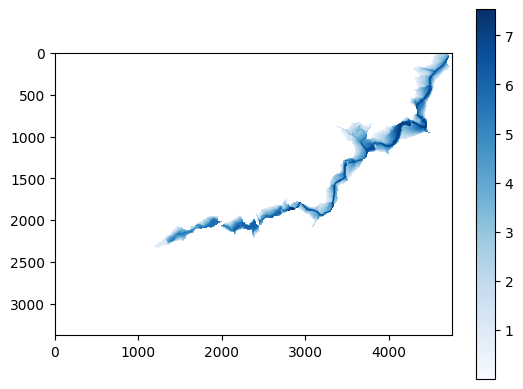

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

with rio.open(pgf.fim_path) as ds:
    fim = ds.read(1)
    fim[fim == ds.nodata] = np.nan

plt.imshow(fim, cmap="Blues")
plt.colorbar()
plt.show()

In [28]:
# save output data file paths we can load our PyGeoFlood instance later with
# pgf = PyGeoFlood.from_paths("data/paths.txt")
pgf.to_paths("data/paths.txt")

Paths written to data/paths.txt


### Temporary workaround to obtain Dinf HAND (optional)
- Dinf HAND creates more realistic FIM than D8 HAND
- The previous workflow uses D8 HAND as input to the FIM step
- Dinf HAND is not yet supported in pygeoflood (coming soon)
- This is a workaround to use TauDEM to obtain Dinf HAND

**Note**: TauDEM must be installed on your system for the following steps to work.

In [29]:
%%bash

# bash script to generate Dinf HAND with TauDEM

# Notes before running this cell:
# - Open taudem_hand.sh and update the first two blocks as necessary
# - Ensure the TauDEM executables pitremove, dinfflowdir, and dinfdistdown are on your path

bash taudem_hand.sh

PitRemove version 5.3.9
Input file data/OC1mTest.tif has projected coordinate system.
Nodata value input to create partition from file: -340282346638528859811704183484516925440.000000
Nodata value recast to float used in partition raster: -340282346638528859811704183484516925440.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Processes: 8
Header read time: 0.150027
Data read time: 0.022143
Compute time: 1.112774
Write time: 0.461220
Total time: 1.746164
DinfFlowDir version 5.3.9
Input file data/OC1mTest_fel.tif has projected coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000


This run may take on the order of 3 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
All slopes evaluated. 539517 flats to resolve.
Draining flats towards lower adjacent terrain
..................................................................................................................................................................................................................................................................................................................................................................................................................
Draining flats away from higher adjacent terrain
.....................................................
Setting directions
Iteration complete. Number of flats remaining: 13592
Draining flats tow

Processors: 8
Header read time: 0.019975
Data read time: 0.046661
Compute Slope time: 1.209763
Write Slope time: 0.558134
Resolve Flat time: 10.030954
Write Flat time: 0.422843
Total time: 12.288331
DinfDistDown -v version 5.3.9
Input file data/OC1mTest_ang.tif has projected coordinate system.
Nodata value input to create partition from file: -340282346638528859811704183484516925440.000000
Nodata value recast to float used in partition raster: -340282346638528859811704183484516925440.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Input file data/OC1mTest_fel.tif has projected coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000
Input file data/OC1mTest_channel_network_raster.tif has projected coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Processors: 8
Read time: 0.113741
Compute time: 4.238761
Write time: 0.413969
Total time: 4.766471


In [30]:
# create FIM with Dinf HAND written in previous step
pgf.inundate(
    custom_hand="data/OC1mTest_HAND_taudem.tif",
    custom_path="data/OC1mTest_HAND_taudem_fim",  # output FIM path
)

Running inundate with parameters:
    custom_hand = data/OC1mTest_HAND_taudem.tif
    custom_flood_stage = None
    custom_segment_catchments_raster = None
    custom_path = data/OC1mTest_HAND_taudem_fim
Flood inundation raster written to data/OC1mTest_HAND_taudem_fim.tif
inundate completed in 1.3180 seconds



### Plot flood inundation map (Dinf HAND based)

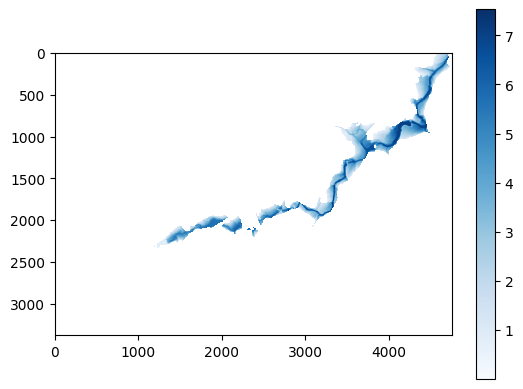

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

with rio.open("data/OC1mTest_HAND_taudem_fim.tif") as ds:
    fim = ds.read(1)
    fim[fim == ds.nodata] = np.nan

plt.imshow(fim, cmap="Blues")
plt.colorbar()
plt.show()